In [1]:
import os
from scipy import stats
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter
from IPython.display import Markdown
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi']=300


Bad key text.latex.preview in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when

In [2]:
before = pd.read_csv('network_before.csv')
before.rename(columns={'outcome':'g'},inplace=True)
before['t']=[0]*len(before)
before['gt'] = before['g']*before['t']
before.drop('strength',axis=1, inplace=True)
after = pd.read_csv('network_after.csv')
after.rename(columns={'outcome':'g'},inplace=True)
after['t']=[1]*len(after)
after['gt'] = after['g']*after['t']
reg_df = pd.concat([before,after])

In [12]:
def DID(network_measure):
    success_before = before[before.g==1][network_measure].mean()
    success_after = after[after.g==1][network_measure].mean()
    
    fail_before = before[before.g==0][network_measure].mean()
    fail_after = after[after.g==0][network_measure].mean()
    
    success_diff = success_after - success_before
    fail_diff = fail_after - fail_before
    
    did = success_diff - fail_diff
    
    return f'{did:.3f}'
 
def DID_pvalue(measure):
    results = ols(f'{measure} ~ g + t + gt', data=reg_df).fit()
    results_summary = results.summary()

    results_as_html = results_summary.tables[1].as_html()
    p = pd.read_html(results_as_html, header=0, index_col=0)[0]['P>|t|']['gt']
    if p >= 0.05:
        return ''
    elif (p < 0.05) and (p>=0.01):
        return '*'
    elif (p < 0.01) and (p>=0.001):
        return '**'
    elif p < 0.001:
        return '***'
    
def DID_error(measure):
    results = ols(f'{measure} ~ g + t + gt', data=reg_df).fit()
    results_summary = results.summary()

    results_as_html = results_summary.tables[1].as_html()
    e = pd.read_html(results_as_html, header=0, index_col=0)[0]['std err']['gt']
    return f'{e:.3f}'

In [4]:
# for measure in before.columns[2:-3]:
#     print (measure)
#     print (stats.spearmanr(before[before.g==1][measure], before[before.g==0][measure]))

In [16]:
results = ols(f'clustering ~ g + t + gt', data=reg_df).fit()
results_summary = results.summary()
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             clustering   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     9.120
Date:                Tue, 09 May 2023   Prob (F-statistic):           5.06e-06
Time:                        11:44:34   Log-Likelihood:                -545.14
No. Observations:                7940   AIC:                             1098.
Df Residuals:                    7936   BIC:                             1126.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0836      0.006     13.275      0.000       0.071       0.096
g           4.075e-05      0.009      0.005      0.996      -0.017       0.017
t              0.0068      0.008      0.812      0.417      -0.010       0.023
gt             0.0290      0.012      2.467      0.014       0.006       0.052
==============================================================================
Omnibus:                     4516.363   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26232.726
Skew:                           2.856   Prob(JB):                         0.00
Kurtosis:                       9.832   Cond. No.                         7.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
measure_map = {'in_degree': 'in-degree',
               'out_degree': 'out-degree',
               'hub': 'hub',
               'authority': 'authority',
               'betweenness': 'betweenness',
               'clustering': 'clustering',
               'copeland': 'Copeland',
               'deg_ratio': 'degree ratio'}

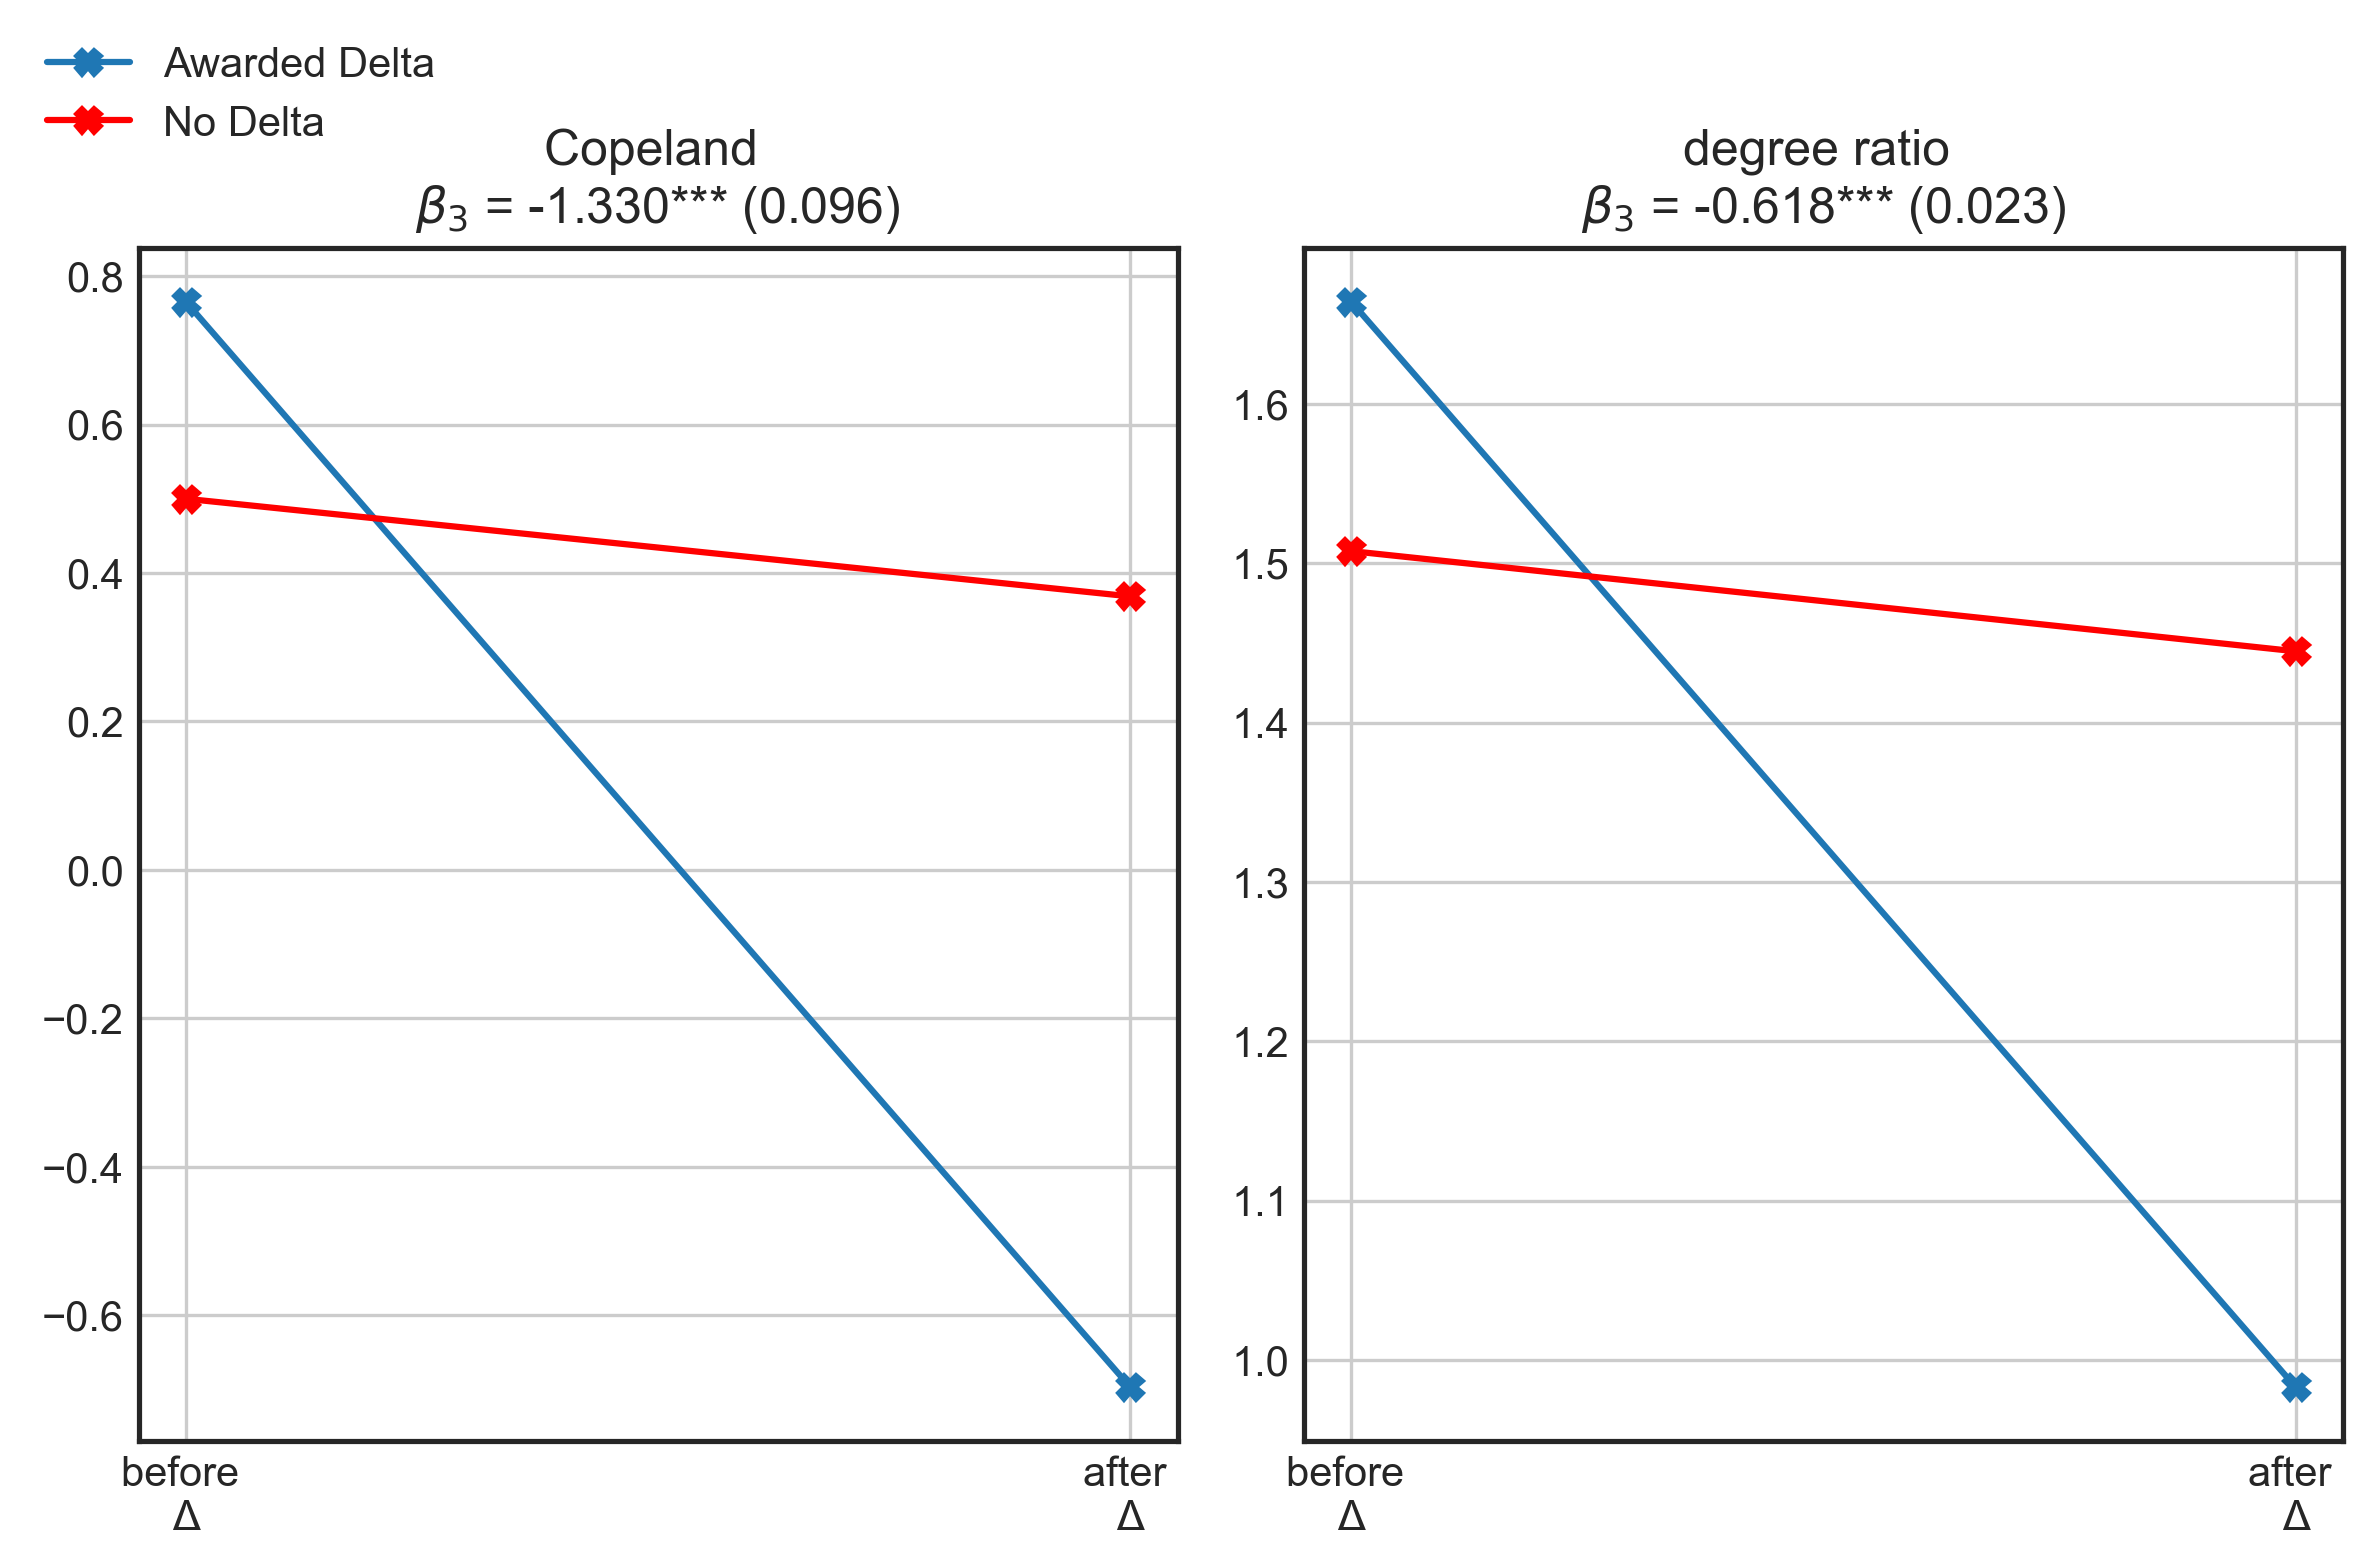

In [13]:
fig, ax = plt.subplots( figsize=(8,5), dpi=300)
i=1
for measure in ['copeland' , 'deg_ratio']:
    plt.subplot(1,2,i)
    plt.plot([before[before.g==1][measure].mean(), after[after.g==1][measure].mean()], label='Awarded Delta', marker='X')
    plt.plot([before[before.g==0][measure].mean(), after[after.g==0][measure].mean()], color='red', label='No Delta', marker='X')
    plt.xticks(np.arange(0,2), ['before \nΔ', 'after \nΔ'])
    plt.title(f'{measure_map[measure]} \n$β_3$ = {DID(measure)}{DID_pvalue(measure)} ({DID_error(measure)})')
    plt.grid()
    i+=1

plt.tight_layout()
plt.legend(bbox_to_anchor=(-.8, 1.2))
plt.show()

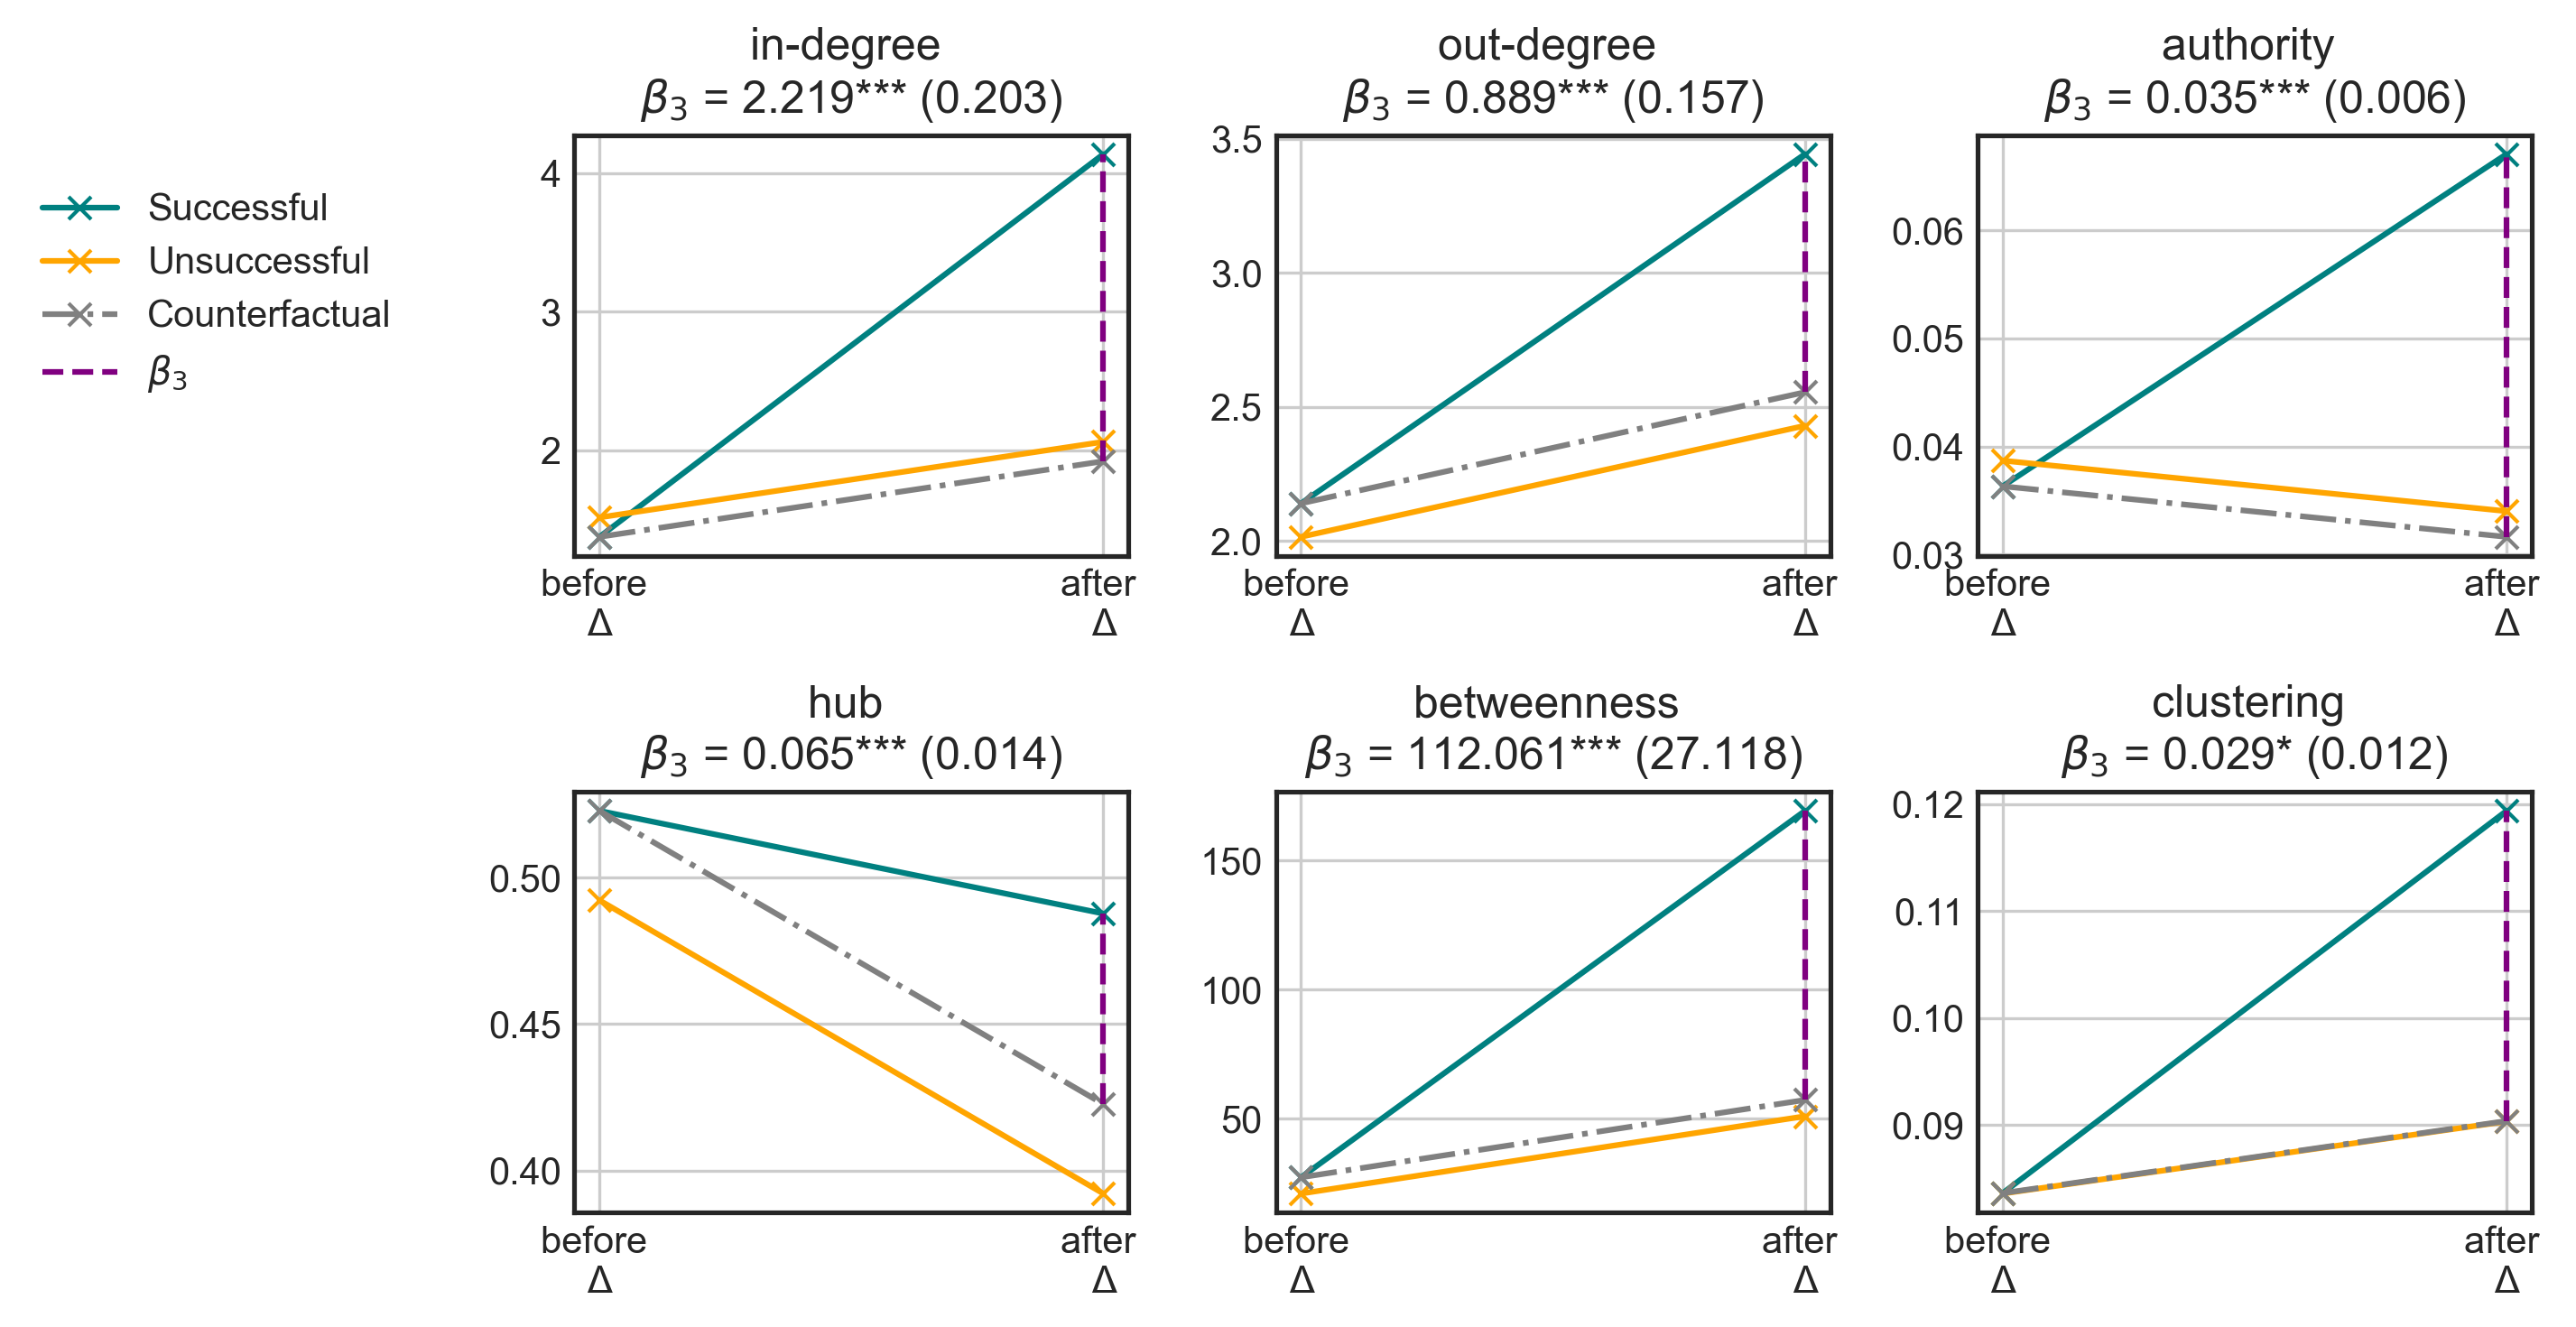

In [14]:
fig, ax = plt.subplots( figsize=(8,5), dpi=300)
i=1
for measure in ['in_degree', 'out_degree', 'authority', 'hub', 'betweenness', 'clustering']:
    plt.subplot(2,3,i)
    base_change = after[after.g==0][measure].mean() - before[before.g==0][measure].mean()
    plt.plot([before[before.g==1][measure].mean(), after[after.g==1][measure].mean()], color='teal', label='Successful', marker='x')
    plt.plot([before[before.g==0][measure].mean(), after[after.g==0][measure].mean()], color='orange', label='Unsuccessful', marker='x')
    plt.plot([before[before.g==1][measure].mean(), before[before.g==1][measure].mean() + base_change], color='grey', label='Counterfactual', linestyle='-.', marker='x')
    plt.vlines(1, before[before.g==1][measure].mean() + base_change, after[after.g==1][measure].mean(), color='purple', linestyle='--', label='$β_3$')
    plt.xticks(np.arange(0,2), ['before \nΔ', 'after \nΔ'])
    plt.title(f'{measure_map[measure]} \n$β_3$ = {DID(measure)}{DID_pvalue(measure)} ({DID_error(measure)})')
    plt.grid()
    i+=1

plt.tight_layout()

plt.legend(bbox_to_anchor=(-2.8, 2.5))
plt.show()